# MNIST Example

This notebook illustrates the use of the proposed in(n)vestigation methods on the mnist dataset.

# Imports

In [1]:
%matplotlib inline  

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import imp
import os

import keras
import keras.backend
import keras.models
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Input
from keras.optimizers import RMSprop, Adam

import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.tests.networks.base
import innvestigate.utils.visualizations as ivis


eutils = imp.load_source("utils", "./utils.py")
mnistutils = imp.load_source("utils_mnist", "./utils_mnist.py")

/home/miriam/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data

Load MNIST data.

In [2]:
# Load data
channels_first = keras.backend.image_data_format == "channels_first"
data = mnistutils.fetch_data(channels_first)
num_classes = len(np.unique(data[1]))

# Test samples for illustrations
images = [(data[2][i].copy(), data[3][i]) for i in range(num_classes)]
label_to_class_name = [str(i) for i in range(num_classes)]

60000 train samples
10000 test samples


Preprocess data.

In [3]:
# Parameter
zero_mean = False

data_preprocessed = (mnistutils.preprocess(data[0],zero_mean), data[1],
                     mnistutils.preprocess(data[2],zero_mean), data[3])

# Model

Create & train a Multilayer Perceptron with two fully connected layers.

In [4]:
# Parameter
batch_size = 64
epochs = 5
activation_type = "relu"

# Create & train model
model, modelp = mnistutils.create_model(channels_first, activation_type, num_classes)
mnistutils.train_model(modelp, data_preprocessed, batch_size=batch_size, epochs=epochs)
model.set_weights(modelp.get_weights())

Epoch 1/5
60000/60000 [==============================] - 19s 314us/step - loss: 0.2232 - acc: 0.9340
Epoch 2/5
60000/60000 [==============================] - 19s 322us/step - loss: 0.0955 - acc: 0.9707
Epoch 3/5
60000/60000 [==============================] - 22s 362us/step - loss: 0.0661 - acc: 0.9797
Epoch 4/5
60000/60000 [==============================] - 18s 298us/step - loss: 0.0515 - acc: 0.9831
Epoch 5/5
60000/60000 [==============================] - 18s 296us/step - loss: 0.0404 - acc: 0.9876
Test loss: 0.06601237294455059
Test accuracy: 0.9797


# Analysis

Use several methods to in(n)vestigate and visualize the learned classifier on a few example images.

In [5]:
# Methods we use and some properties.
methods = [
    # NAME                                             POSTPROCESSING       TITLE

    # Show input.
    ("input",                 {},                       mnistutils.image,   "Input"),

    # Function
    ("gradient",              {},                       mnistutils.graymap, "Gradient"),
    ("smoothgrad",            {"noise_scale": 50},      mnistutils.graymap, "SmoothGrad"),
    ("integrated_gradients",  {},                       mnistutils.graymap, ("Integrated", "Gradients")),

    # Signal
    ("deconvnet",             {},                       mnistutils.bk_proj, "Deconvnet"),
    ("guided_backprop",       {},                       mnistutils.bk_proj, ("Guided", "Backprop"),),
    ("pattern.net",           {},                       mnistutils.bk_proj, "PatterNet"),

    # Interaction
    ("pattern.attribution",   {},                       mnistutils.heatmap, "Pattern", "Attribution"),
    ("lrp.z_baseline",        {},                       mnistutils.heatmap, "LRP-Z"),
]

In [6]:
# Create analyzers.

pattern_type = activation_type
analyzers = []
for method in methods:
    analyzer = innvestigate.create_analyzer(method[0],
                                            model,
                                            **method[1])
    analyzer.fit(data_preprocessed[0], pattern_type=pattern_type,
                 batch_size=256, verbose=1)
    analyzers.append(analyzer)

# Create analysis.
analysis = np.zeros([len(images), len(analyzers), 28, 28, 3])
text = []
for i, (image, y) in enumerate(images):
    image = image[None, :, :, :]
    # Predict label.
    x = mnistutils.preprocess(image, zero_mean)
    prob = modelp.predict_on_batch(x)[0]
    y_hat = prob.argmax()

    text.append(("%s" %label_to_class_name[y], "%.2f" % prob.max(), "%s" %label_to_class_name[y_hat]))

    for aidx, analyzer in enumerate(analyzers):
        is_input_analyzer = methods[aidx][0] == "input"
        # Analyze.
        a = analyzer.analyze(image if is_input_analyzer else x)
        # Postprocess.
        if not is_input_analyzer:
            a = mnistutils.postprocess(a)
        a = methods[aidx][2](a)
        analysis[i, aidx] = a[0]

/home/miriam/anaconda3/lib/python3.6/site-packages/innvestigate-0.1-py3.6.egg/innvestigate/analyzer/base.py:81: RuntimeWarning: This analyzer does not need to be trained. Still fit() is called.
  " Still fit() is called.", RuntimeWarning)


Epoch 1/1
235/235 [==============================] - 20s 87ms/step - loss: 2.0000 - broadcast_1_loss: 1.0000 - broadcast_2_loss: 1.0000
Epoch 1/1
235/235 [==============================] - 20s 84ms/step - loss: 2.0000 - broadcast_3_loss: 1.0000 - broadcast_4_loss: 1.0000


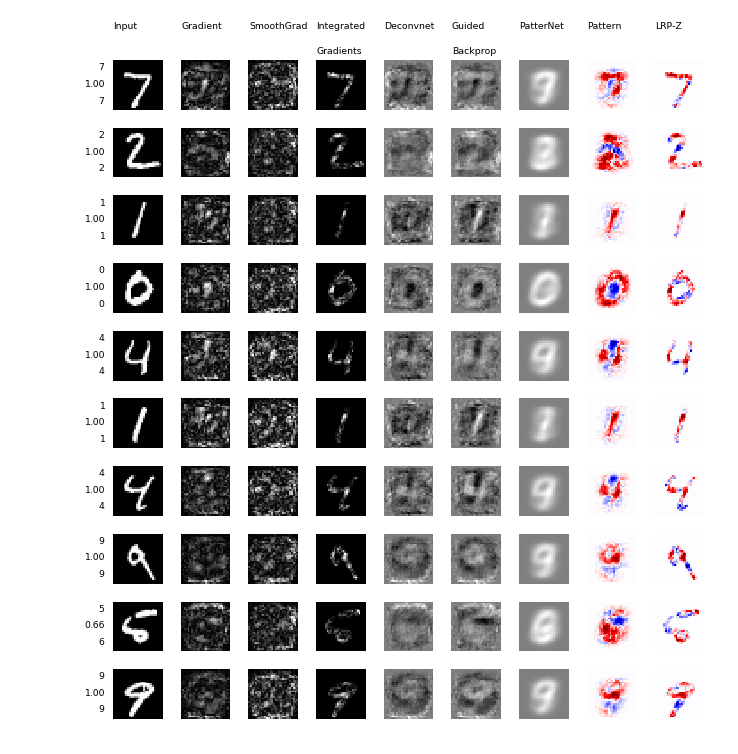

In [7]:
# Plot the analysis.

grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]
row_labels = text
col_labels = [method[3] for method in methods]

eutils.plot_image_grid(grid, row_labels, col_labels,
                       row_label_offset=5,
                       col_label_offset=15,
                       is_fontsize_adaptive=False,
                       usetex=False)